# Загрузка библиотек и данных

In [1]:
import json
import bz2
import re
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:38, 5255.66it/s]



Посмотрим на пример отзыва:

In [3]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [4]:
df = pd.DataFrame(responses)

In [5]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


# Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [7]:
df.city = df.city.apply(lambda x: re.sub('[^а-я]', ' ', x[3:].lower()) if x is not None else x)

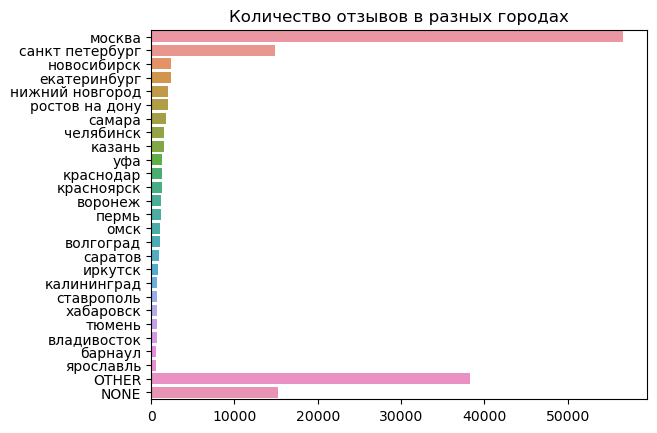

In [8]:
data = df.city.value_counts()
top = 25
other = data[top:].values.sum()
nans = len(df) - data.values.sum()
sns.barplot(x=list(data.values[:top])+[other, nans], y=list(data.index[:top])+['OTHER', 'NONE'])
plt.title('Количество отзывов в разных городах');

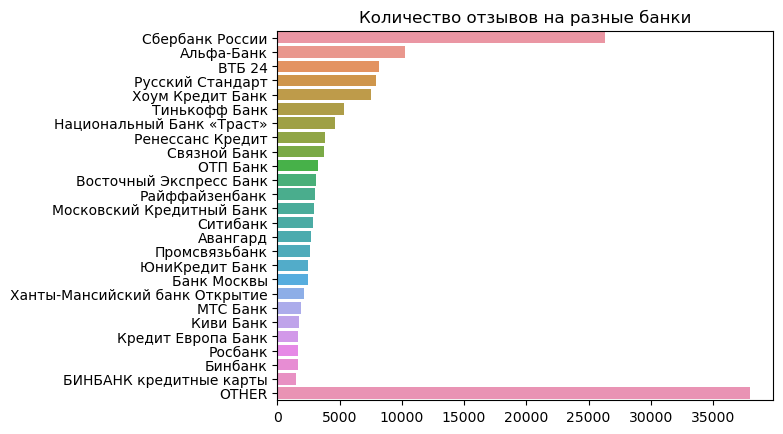

In [9]:
data = df.bank_name.value_counts()
top = 25
other = data[top:].values.sum()
sns.barplot(x=list(data.values[:top])+[other], y=list(data.index[:top])+['OTHER'])
plt.title('Количество отзывов на разные банки');

2. Постройте гистограмы длин отзывов в символах и в словах

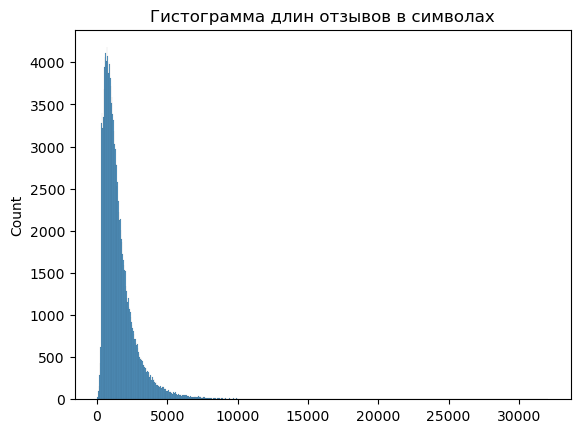

In [10]:
sns.histplot([len(x) for x in df.text])
plt.title('Гистограмма длин отзывов в символах');

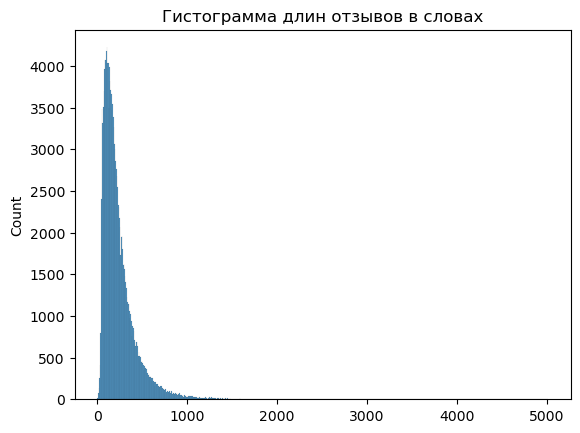

In [11]:
sns.histplot([len(x.split(' ')) for x in df.text])
plt.title('Гистограмма длин отзывов в словах');

3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

In [12]:
# nltk.download('punkt')
from string import punctuation
from nltk.tokenize import word_tokenize

corpus = [token for x in df.text for token in word_tokenize(x.lower(), language='russian')
          if not all(c in punctuation for c in token)]
print(len(corpus))

36195788


In [13]:
from collections import Counter

freq_dict = Counter(corpus)
print('10 самых частых слов')
freq_dict.most_common(10)

10 самых частых слов


[('в', 1322462),
 ('и', 1054460),
 ('не', 851739),
 ('на', 704396),
 ('что', 621783),
 ('я', 573896),
 ('с', 454471),
 ('по', 365188),
 ('мне', 320695),
 ('банка', 263957)]

In [14]:
# nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('russian')

freq_dict_no_stopwords = {k: v for k, v in freq_dict.items() if k not in sw}
print('10 самых частых слов без стоп-слов')
sorted(freq_dict_no_stopwords.items(), key=lambda x: x[1], reverse=True)[:10]

10 самых частых слов без стоп-слов


[('банка', 263957),
 ('банк', 196303),
 ('это', 183054),
 ('деньги', 130062),
 ('карту', 104947),
 ('карты', 100877),
 ('кредит', 80282),
 ('день', 75996),
 ('заявление', 69524),
 ('отделение', 66468)]

In [15]:
from pymystem3 import Mystem
import random
mystem_analyzer = Mystem(entire_input=False)

corpus_lemmas = [token for x in random.choices(df.text, k=1000) for
                 token in mystem_analyzer.lemmatize(x) if token not in sw]
print(len(corpus_lemmas))

137572


In [16]:
freq_dict_lemmas = Counter(corpus_lemmas)
print('10 самых частых лемм')
freq_dict_lemmas.most_common(10)

10 самых частых лемм


[('банк', 3890),
 ('карта', 2032),
 ('это', 1409),
 ('деньги', 1172),
 ('день', 1094),
 ('кредит', 960),
 ('который', 945),
 ('счет', 923),
 ('клиент', 882),
 ('отделение', 877)]

In [17]:
print('10 самых частых существительных среди лемм\n')
x = 0
for word in freq_dict_lemmas.most_common():
    if mystem_analyzer.analyze(word[0])[0]['analysis'][0]['gr'][:2] == 'S,':
        print(word),
        x += 1
        if x == 10: break

10 самых частых существительных среди лемм

('банк', 3890)
('карта', 2032)
('деньги', 1172)
('день', 1094)
('кредит', 960)
('счет', 923)
('клиент', 882)
('отделение', 877)
('сотрудник', 800)
('мочь', 734)


4. Постройте кривые Ципфа и Хипса

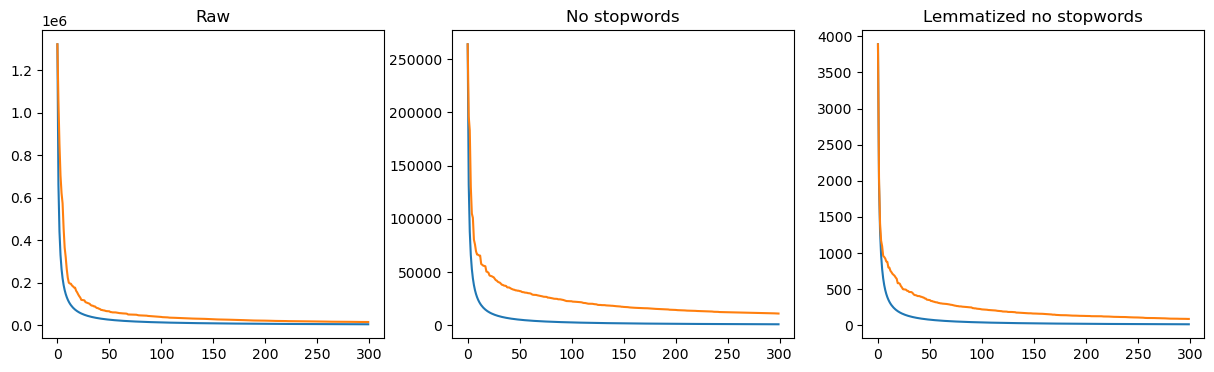

In [18]:
n = 300
fig, axs = plt.subplots(1, 3, figsize=(15,4))
titles = ['Raw', 'No stopwords', 'Lemmatized no stopwords']

for i, freq in enumerate([freq_dict, freq_dict_no_stopwords, freq_dict_lemmas]):
    axs[i].plot(range(n), [max(freq.values())/i for i in range(1, n+1)])
    axs[i].plot(range(n), sorted(freq.values(), reverse=True)[:n])
    axs[i].set_title(titles[i])

100%|██████████| 153499/153499 [04:25<00:00, 577.31it/s]


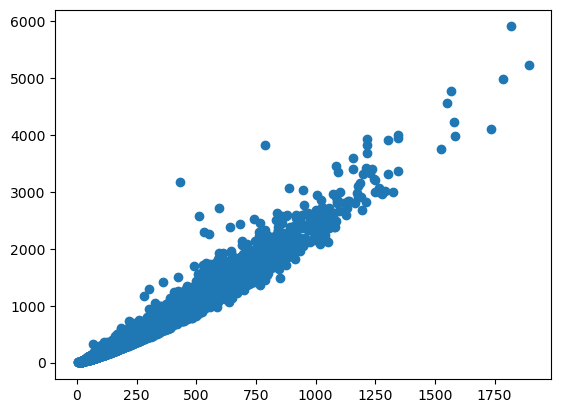

In [73]:
n_words = []
n_tokens = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    tokens = word_tokenize(row['text'].lower(), language='russian')
    n_words.append(len(tokens))
    n_tokens.append(len(set(tokens)))

plt.scatter(n_tokens, n_words)

5. Ответьте на следующие вопросы:
- Какое слово встречается чаще, "сотрудник" или "клиент"?
- Сколько раз встречается слова "мошенничество" и "доверие"?

In [20]:
print('Частотность среди всех слов:')
print('сотрудник:', freq_dict['сотрудник'], '||', 'клиент:', freq_dict['клиент'])
print('мошенничество:', freq_dict['мошенничество'], '||',  'доверие:', freq_dict['доверие'])
print()

print('Частотность среди лемм')
print('сотрудник:', freq_dict_lemmas['сотрудник'], '||',  'клиент:', freq_dict_lemmas['клиент'])
print('мошенничество:', freq_dict_lemmas['мошенничество'], '||',  'доверие:', freq_dict_lemmas['доверие'])

Частотность среди всех слов:
сотрудник: 30994 || клиент: 17754
мошенничество: 1102 || доверие: 1153

Частотность среди лемм
сотрудник: 800 || клиент: 882
мошенничество: 11 || доверие: 10


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру **`tf-idf`**, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True,
                        tokenizer=word_tokenize,
                        stop_words=sw + list(punctuation),
                        ngram_range=(1, 2))

In [22]:
bow = tfidf.fit_transform(df.text)
vocab = {v: k for k, v in tfidf.vocabulary_.items()}

In [23]:
words_rating_1 = np.empty((1, bow.shape[1]))
words_rating_5 = np.empty((1, bow.shape[1]))

for text in bow[df.rating_grade == 1]:
    words_rating_1 += text

for text in bow[df.rating_grade == 5]:
    words_rating_5 += text

In [28]:
top = 500
rating_1 = np.argsort(np.array(words_rating_1)[0])[-top:][::-1]
rating_5 = np.argsort(np.array(words_rating_5)[0])[-top:][::-1]

top_words_rating_1 = [x for x in rating_1 if x not in rating_5]
top_words_rating_5 = [x for x in rating_5 if x not in rating_1]

In [29]:
print('Топ-10 ключевых слов и биграм в отрицательных отзывах\n')
x = 0
for word in top_words_rating_1:
    if x < 10:
        print(vocab[word])
        x += 1
    elif x < 20:
        if len(vocab[word].split(' ')) > 1:
            print(vocab[word])
            x += 1
    else: break

Топ-10 ключевых слов и биграм в отрицательных отзывах

почему
номер
никто
звоню
снова
заявления
ответа
говорят
претензию
могут
сих пор
отделение банка
денежных средств
денежные средства
горячую линию
сотрудник банка
сотрудники банка
рабочих дней
горячей линии
написать заявление


In [30]:
print('Топ-10 ключевых слов и биграм в положительных отзывах\n')
x = 0
for word in top_words_rating_5:
    if x < 10:
        print(vocab[word])
        x += 1
    elif x < 20:
        if len(vocab[word].split(' ')) > 1:
            print(vocab[word])
            x += 1
    else: break

Топ-10 ключевых слов и биграм в положительных отзывах

быстро
приятно
благодарность
банков
удобно
пользуюсь
оперативно
доволен
выразить
очередей
очень удобно
очень быстро
хочу выразить
выразить благодарность
являюсь клиентом
клиентом банка
большое спасибо
огромное спасибо
очень приятно
других банках


# Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [74]:
import pymorphy3
m = pymorphy3.MorphAnalyzer()

mystopwords = stopwords.words('russian') + ['это', 'наш', 'тыс', 'млн', 'млрд', 'также', 'т', 'д',
                                            'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой']
ru_words = re.compile('[А-Яа-я]+')

def words_only(text):
    return ' '.join(ru_words.findall(text))

def lemmatize(text, mystem=m):
    try:
        return ' '.join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()
    except:
        return ' '

def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return ' '.join([w for w in text.split() if not w in mystopwords])
    except:
        return ' '

def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [81]:
# %%time
# df.text = df.text.apply(preprocess)
# df.to_csv('df.csv', index=False)

CPU times: total: 1h 30min 33s
Wall time: 1h 31min 19s


In [114]:
df_saved = pd.read_csv('df.csv').dropna(subset='text')

In [116]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import lsimodel

In [117]:
texts = [text.split() for text in df_saved.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [118]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [120]:
lsi_5 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lsi_5.show_topics(5)

CPU times: total: 1min 17s
Wall time: 32.9 s


[(0,
  '0.198*"карта" + 0.136*"кредит" + 0.116*"деньга" + 0.111*"заявление" + 0.108*"счёт" + 0.102*"банкомат" + 0.102*"вклад" + 0.102*"отделение" + 0.098*"сбербанк" + 0.098*"сумма"'),
 (1,
  '-0.473*"вклад" + 0.336*"кредит" + 0.167*"страховка" + 0.146*"платёж" + 0.144*"задолженность" + 0.135*"погашение" + -0.133*"банкомат" + -0.126*"карта" + -0.126*"очередь" + -0.119*"открыть"'),
 (2,
  '-0.412*"вклад" + 0.262*"банкомат" + 0.260*"карта" + -0.208*"кредит" + 0.205*"сбербанк" + -0.145*"страховка" + 0.139*"операция" + -0.137*"договор" + 0.126*"средство" + 0.124*"заявление"'),
 (3,
  '-0.271*"вклад" + -0.211*"сумма" + 0.209*"заявка" + 0.198*"номер" + -0.181*"руб" + -0.165*"договор" + 0.157*"звонок" + -0.157*"платёж" + -0.149*"средство" + -0.148*"погашение"'),
 (4,
  '0.279*"номер" + 0.275*"вклад" + 0.237*"звонок" + -0.231*"страховка" + -0.191*"заявка" + 0.172*"ваш" + 0.149*"поступать" + 0.139*"персональный" + 0.138*"данные" + 0.136*"телефон"')]

**Здесь, пожалуй, можно однозначно интерпретировать тему номер 2. Речь может идти о карточных операциях в банкоматах Сбербанка:**

`-0.412*"вклад" + 0.262*"банкомат" + 0.260*"карта" + -0.208*"кредит" + 0.205*"сбербанк" + -0.145*"страховка" + 0.139*"операция" + -0.137*"договор" + 0.126*"средство" + 0.124*"заявление"`

**Под темой номер 5, возможно, собраны отзывы на тему телефонных звонков и персональных данных:**

`0.279*"номер" + 0.275*"вклад" + 0.237*"звонок" + -0.231*"страховка" + -0.191*"заявка" + 0.172*"ваш" + 0.149*"поступать" + 0.139*"персональный" + 0.138*"данные" + 0.136*"телефон"`

In [121]:
lsi_15 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=15)
lsi_15.show_topics(5)

CPU times: total: 1min 39s
Wall time: 43.5 s


[(0,
  '0.197*"карта" + 0.135*"кредит" + 0.116*"деньга" + 0.111*"заявление" + 0.108*"счёт" + 0.103*"банкомат" + 0.102*"вклад" + 0.102*"отделение" + 0.098*"сбербанк" + 0.097*"сумма"'),
 (1,
  '-0.383*"вклад" + 0.360*"кредит" + -0.214*"банкомат" + -0.171*"карта" + 0.168*"страховка" + 0.148*"платёж" + 0.147*"задолженность" + 0.143*"погашение" + -0.121*"деньга" + 0.116*"звонок"'),
 (2,
  '-0.505*"вклад" + 0.274*"банкомат" + 0.217*"карта" + 0.185*"сбербанк" + 0.133*"заявление" + -0.128*"кредит" + 0.121*"операция" + -0.121*"договор" + 0.118*"средство" + 0.115*"деньга"'),
 (3,
  '-0.278*"вклад" + -0.219*"сумма" + -0.190*"руб" + 0.189*"номер" + 0.177*"заявка" + -0.157*"платёж" + -0.153*"договор" + -0.149*"погашение" + -0.146*"рубль" + -0.146*"процент"'),
 (4,
  '-0.345*"карта" + 0.281*"вклад" + 0.268*"номер" + -0.192*"страховка" + 0.192*"звонок" + -0.168*"лимит" + -0.157*"кредитный" + -0.147*"заявка" + 0.138*"телефон" + 0.137*"ваш"')]

**В теме номер 0 опять фигурирует Сбербанк. Остальные ключевые слова видимо относятся к его банковским продуктам:**

`'0.197*"карта" + 0.135*"кредит" + 0.116*"деньга" + 0.111*"заявление" + 0.108*"счёт" + 0.103*"банкомат" + 0.102*"вклад" + 0.102*"отделение" + 0.098*"сбербанк" + 0.097*"сумма"`

In [122]:
lsi_30 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)
lsi_30.show_topics(5)

CPU times: total: 1min 36s
Wall time: 39.6 s


[(0,
  '0.197*"карта" + 0.135*"кредит" + 0.117*"деньга" + 0.111*"заявление" + 0.108*"счёт" + 0.103*"банкомат" + 0.102*"вклад" + 0.102*"отделение" + 0.098*"сбербанк" + 0.098*"сумма"'),
 (1,
  '0.365*"кредит" + -0.363*"вклад" + -0.225*"банкомат" + -0.179*"карта" + 0.169*"страховка" + 0.146*"задолженность" + 0.142*"платёж" + 0.140*"погашение" + -0.125*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.516*"вклад" + 0.271*"банкомат" + 0.210*"карта" + 0.182*"сбербанк" + 0.134*"заявление" + -0.120*"очередь" + 0.117*"операция" + -0.116*"кредит" + -0.114*"договор" + 0.113*"средство"'),
 (3,
  '-0.263*"вклад" + -0.219*"сумма" + 0.196*"номер" + -0.185*"руб" + 0.180*"заявка" + -0.160*"погашение" + -0.158*"платёж" + -0.156*"договор" + 0.151*"звонок" + -0.144*"рубль"'),
 (4,
  '0.323*"вклад" + 0.275*"номер" + -0.257*"карта" + -0.214*"страховка" + 0.195*"звонок" + -0.190*"заявка" + 0.143*"ваш" + 0.142*"телефон" + -0.140*"кредит" + -0.124*"лимит"')]

**В теме номер 1 отзывы могут говорить о звонках, связанных с задолженностями по кредитам у клиентов**

`0.365*"кредит" + -0.363*"вклад" + -0.225*"банкомат" + -0.179*"карта" + 0.169*"страховка" + 0.146*"задолженность" + 0.142*"платёж" + 0.140*"погашение" + -0.125*"деньга" + 0.117*"звонок"`

2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [145]:
bank_names = ['сбербанк', 'альфа', 'втб']
models = [lsi_5, lsi_15, lsi_30]

for model in models:
    for topic in model.show_topics():
        for name in bank_names:
            if name in topic[1]:
                print(name, '\n', topic[1], '\n')

сбербанк 
 0.198*"карта" + 0.136*"кредит" + 0.116*"деньга" + 0.111*"заявление" + 0.108*"счёт" + 0.102*"банкомат" + 0.102*"вклад" + 0.102*"отделение" + 0.098*"сбербанк" + 0.098*"сумма" 

сбербанк 
 -0.412*"вклад" + 0.262*"банкомат" + 0.260*"карта" + -0.208*"кредит" + 0.205*"сбербанк" + -0.145*"страховка" + 0.139*"операция" + -0.137*"договор" + 0.126*"средство" + 0.124*"заявление" 

сбербанк 
 0.197*"карта" + 0.135*"кредит" + 0.116*"деньга" + 0.111*"заявление" + 0.108*"счёт" + 0.103*"банкомат" + 0.102*"вклад" + 0.102*"отделение" + 0.098*"сбербанк" + 0.097*"сумма" 

сбербанк 
 -0.505*"вклад" + 0.274*"банкомат" + 0.217*"карта" + 0.185*"сбербанк" + 0.133*"заявление" + -0.128*"кредит" + 0.121*"операция" + -0.121*"договор" + 0.118*"средство" + 0.115*"деньга" 

сбербанк 
 0.237*"заявление" + 0.227*"сбербанк" + 0.223*"страховка" + -0.213*"платёж" + 0.190*"заявка" + 0.173*"страхование" + 0.144*"документ" + -0.138*"задолженность" + 0.137*"договор" + 0.134*"рассмотрение" 

сбербанк 
 -0.287*"вклад

Довольно много тем включают название Сбербанка, некоторые темы также включают название Альфа-Банка. Отзывы по этим двум банкам в сумме составляют почти четверть от всех отзывов, значит можно предположить, что названия самих банков в текстах отзывов встречаются так же часто, как и обычные слова. При этом отзывы о конкретном банке вряд-ли будут часто содержать названия других банков. Модель скорее всего заметила, что слова `сбербанк` и `альфа` появляются только в определенных отзывах и включила их в качестве ключевых слов для тем, объединяющих такие отзывы. На мой взгляд это нормальное ожидаемое поведение модели.

In [151]:
df_saved.bank_name.value_counts(normalize=True).head()

bank_name
Сбербанк России     0.171515
Альфа-Банк          0.066607
ВТБ 24              0.053317
Русский Стандарт    0.051747
Хоум Кредит Банк    0.049180
Name: proportion, dtype: float64

# Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [251]:
from sklearn.model_selection import train_test_split

df_saved = pd.read_csv('df.csv').dropna(subset='text')
data = df_saved[df_saved.rating_grade.isin([1, 5])][['text', 'rating_grade']].sample(frac=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data.text,
                                                    data.rating_grade.apply(lambda x: 0 if x == 5 else x),
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=data.rating_grade)

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.

In [252]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def review_classifier(ngram_range=(1, 1), analyzer='word'):
    tfidf = TfidfVectorizer(ngram_range=ngram_range, analyzer=analyzer)
    X_train_tf = tfidf.fit_transform(X_train)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_tf, y_train)

    preds = clf.predict(tfidf.transform(X_test))
    print(classification_report(y_test, preds))

review_classifier(ngram_range=(1, 1))

              precision    recall  f1-score   support

         0.0       0.97      0.59      0.74       291
         1.0       0.89      0.99      0.94       951

    accuracy                           0.90      1242
   macro avg       0.93      0.79      0.84      1242
weighted avg       0.91      0.90      0.89      1242



In [253]:
review_classifier(ngram_range=(2, 2))

              precision    recall  f1-score   support

         0.0       0.96      0.47      0.63       291
         1.0       0.86      0.99      0.92       951

    accuracy                           0.87      1242
   macro avg       0.91      0.73      0.77      1242
weighted avg       0.88      0.87      0.85      1242



In [254]:
review_classifier(ngram_range=(3, 3))

              precision    recall  f1-score   support

         0.0       0.89      0.09      0.16       291
         1.0       0.78      1.00      0.88       951

    accuracy                           0.78      1242
   macro avg       0.84      0.54      0.52      1242
weighted avg       0.81      0.78      0.71      1242



In [258]:
review_classifier(ngram_range=(3, 5), analyzer='char_wb')

              precision    recall  f1-score   support

         0.0       0.96      0.66      0.79       291
         1.0       0.91      0.99      0.95       951

    accuracy                           0.92      1242
   macro avg       0.94      0.83      0.87      1242
weighted avg       0.92      0.92      0.91      1242



In [263]:
review_classifier(ngram_range=(3, 6), analyzer='char_wb')

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81       291
         1.0       0.92      0.99      0.95       951

    accuracy                           0.92      1242
   macro avg       0.93      0.85      0.88      1242
weighted avg       0.92      0.92      0.92      1242



**Для сравнения моделей я взял 10% отзывов из исходных данных. Из построенных моделей наилучшее качество показал классификатор, обученный на символьных 3-6-граммах. Классификатор на словесных униграммах показал сравнимое качество. Модели на словесных биграммах и триграммах дают заметно более плохое качество.**